# Eye Tracking Demo in PyTorch

In this notebook, I show a quick and simple demonstration on how you can get a eye tracking CNN to work from scratch using your webcam. By "from scratch" I mean no pretrained networks necessary and no external datasets necessary. The data will be scraped locally by the user using their webcam and mouse, and then trained locally on the machine. The notebook is structured as follows:

1. We build a dataloader that can fetch images from the webcam and get the "targets" from the mouse. We then collect some data by running the dataloader. The user must move their mouse around no the screen while following the mouse closely with their eyes.
2. We design a simple CNN that can take in images of the eyes and predict where on the screen the user is looking
3. We train the CNN on the data we collected in step 1
4. We test the network live and qualitatively

### Imports

In [1]:
import pyautogui as pag
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from tqdm import tqdm
import random

import dlib
import imutils
from PIL import Image

/home/kjw/anaconda3/envs/eyems2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Dataloader

In this step we want to build a dataloader that can fetch images from the webcam and read our current mouse location on the screen. For reading the webcam, we use OpenCV and PyAutoGui is used to read and control the mouse movement.

First, we'll start by defining a CamCapture object which captures images from the webcam.

Video Capture Started
Video Capture Stopped


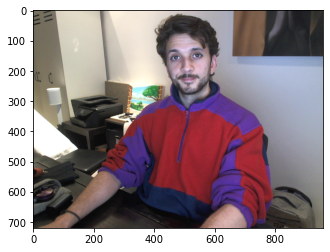

In [2]:
class CamCapture(object):
    def __init__(self, res=(960, 720)):
        """
        Instantiates the CamCapture object with a given resolution
        """
        self.res = res
        self.vc = self.videocap_device()
        self.start()
    
    def videocap_device(self):
        """
        Instantiates a video capturing device using opencv
        """
        # Define a videocapture (assuming there is only one webcam)
        vc = cv2.VideoCapture(0)
        # Set the resolution to 960x720
        vc.set(cv2.CAP_PROP_FRAME_WIDTH, self.res[0])
        vc.set(cv2.CAP_PROP_FRAME_HEIGHT, self.res[1])
        return vc
        
    def start(self):
        """
        Starts video capture
        """
        enabled,_ = self.vc.read()
        if not enabled:
            self.vc = self.videocap_device()
        print('Video Capture Started')
        
    def stop(self):
        """
        Stops video capture
        """
        enabled,_ = self.vc.read()
        if enabled:
            self.vc.release()
        print('Video Capture Stopped')
        
    def capture_image(self):
        """
        Takes a single image from the webcam
        """
        _, frame = self.vc.read()
        return frame
    
# Create CamCapture object, capture a frame, stop the capturing
cam = CamCapture()
frame = cam.capture_image()
cam.stop()

# Show the image
plt.imshow(frame[:,:,[2,1,0]])
plt.show()

Now we want to build a FeatureExtractor object, which extracts features from the image. In this project, the features will consists only of images of the eyes, but we also want to provide the network with information on where in the webcam frame the face and eyes are located. For this, we use Haar Cascade detections for the face and eyes. We include a CamCapture inside of the FeatureExtractor so that it can also take images from the camera.

In [3]:
class FeatureExtractor(object):
    def __init__(self, res=(960, 720)):
        """
        Instantiates FeatureExtractor object
        """
        # Create face, eye, and landmark cascade models
        self.face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        self.eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
        
        # Start cam capture
        self.cam = CamCapture()
        
    def extract_features(self):
        """
        Extracts features all features from a webcam image
        """
        frame = self.cam.capture_image()
        face = self.extract_face(frame)
        if face is None:
            return None
        face, face_center, offsets = face
        eyes, eyes_centers = self.extract_eyes(frame, offsets)
        if eyes is None or eyes_centers is None:
            return None
        
        face_center = torch.tensor(self.normalize_center(face_center))
        eye1_center = self.normalize_center(eyes_centers[0])
        eye2_center = self.normalize_center(eyes_centers[1])
        eyes_centers = np.array([eye1_center, eye2_center])
        eyes_centers = torch.tensor(eyes_centers)
        
        
        return frame, face, face_center, eyes, eyes_centers
    
    def normalize_center(self, center):
        """
        Normalizes camera coordinates in a [0,1] range based on the camera resolution
        """
        center = np.array((center[0]/self.cam.res[0], center[1]/self.cam.res[1]))
        return center
        
        
    def extract_face(self, frame):
        """
        Extracts the face, face center point and offset coordinates from the extracted face frame
        """
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Using face cascade model, detect faces from grayscale image
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 4)

        # Extract the first face (if any are found)
        if len(faces) > 0:
            x,y,w,h = faces[0,:]
            face_found = frame[y:y+h, x:x+w]
            face_centerpoint = (x+(w/2), y+(h/2))
            return face_found, face_centerpoint, (x,y,w,h)
        else:
            return None
        
    def extract_eyes(self, frame, offsets):
        """
        Given a frame and offsets (bbox), detects and extracts the eyes from the bbox in the frame
        """
        x,y,w,h = offsets
        frame = frame[y:y+h, x:x+w]
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Using eye cascade model, extract eyes from grayscale image
        eyes = self.eye_cascade.detectMultiScale(gray, 1.1, 4)

        # Extract first two eyes if they're found (otherwise return None)
        if len(eyes) > 1:
            x1,y1,w1,h1 = eyes[0,:]
            eye1 = frame[y1:y1+h1, x1:x1+w1]
            eye1_centerpoint = ((x+x1)+(w1/2), (y+y1)+(h1/2))
            x2,y2,w2,h2 = eyes[1,:]
            eye2 = frame[y2:y2+h2, x2:x2+w2]
            eye2_centerpoint = ((x+x2)+(w2/2), (y+y2)+(h2/2))
            return (eye1, eye2), (eye1_centerpoint, eye2_centerpoint)
        else:
            return None, None
        
    def plot_features(self, frame, face, face_center, eyes, eyes_centers):
        """
        Plots the features, which can be used as a useful sanity check if the coordinates make sense
        """
        # Unnormalize the face center coordinates to coordinates fitting the camera's resolution
        face_center = (int(face_center[0]*self.cam.res[0]), int(face_center[1]*self.cam.res[1]))
        
        # Do the same with the eyes
        eye1_center, eye2_center = eyes_centers
        eye1_center = (int(eye1_center[0]*self.cam.res[0]), int(eye1_center[1]*self.cam.res[1]))
        eye2_center = (int(eye2_center[0]*self.cam.res[0]), int(eye2_center[1]*self.cam.res[1]))
        
        # Draw the coordinates for the center of the face and eyes onto the frame
        cv2.circle(frame, face_center, radius=5, color=[255,0,0], thickness=5)
        cv2.circle(frame, eye1_center, radius=5, color=[255,0,0], thickness=5)
        cv2.circle(frame, eye2_center, radius=5, color=[255,0,0], thickness=5)
        
        # Title the image and plot it
        plt.title("Coordinates plotted on camera image")
        plt.imshow(frame[:,:,[2,1,0]])
        plt.show()
        
        # Plot an image of the two eyes seperately
        plt.title("Eye 1")
        plt.imshow(eyes[0][:,:,[2,1,0]])
        plt.show()
        
        plt.title("Eye 2")
        plt.imshow(eyes[1][:,:,[2,1,0]])
        plt.show()
        
    def start(self):
        """
        Start recording from the webcam
        """
        self.cam.start()
        
    def stop(self):
        """
        Stop recording from the webcam
        """
        self.cam.stop()

#### A quick test

Let's quickly test out our FeatureExtractor

Video Capture Started
Video Capture Stopped


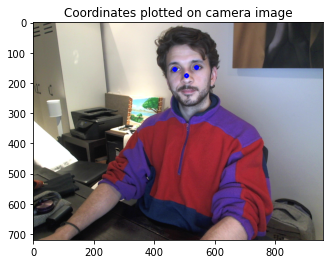

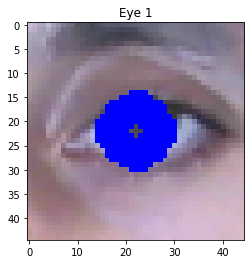

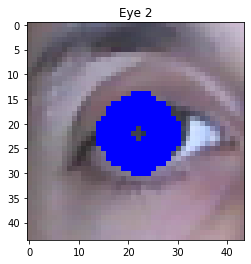

In [4]:
feature_extractor = FeatureExtractor()
frame, face, face_center, eyes, eyes_centers = feature_extractor.extract_features()
feature_extractor.stop()
feature_extractor.plot_features(frame, face, face_center, eyes, eyes_centers)

#### PyAutoGui Test

Now lets see how we can read the screen resolution and current mouse position, and how to set the current mouse position to the center of the screen, which we'll need once we want to test out our network.

In [5]:
res = pag.size()
print(f'Screen Resolution: {res.width}x{res.height}')

Screen Resolution: 3440x1440


In [6]:
# Reading the position
curr_pos = pag.position()
print(f'Current position: ({curr_pos[0]},{curr_pos[1]})')

Current position: (1880,740)


In [7]:
# Moving mouse to center
pag.moveTo(res[0]/2, res[1]/2)

#### Defining our dataloader

Now we can put these things together to build a dataloader. The dataloader needs to be able to do three things:
* Collect data by capturing images from the webcam and reading the mouse position
* Sample batches of the data for training
* Sample single instances live from the webcam for a demo

Things to think about are the device we want the tensors to be on, normalizing the data whether it be the images or the mouse positions or coordinates in the webcam images, cropping and converting the images to greyscale.

In [8]:
# Define device on which to train/run inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
class EyeMouseDataloader(object):
    """
    Class which defines a dataloader that records webcam and mouse movement for 
    data collection phase, and allows for sampling batches of training samples 
    to train on.
    """
    def __init__(self, device, crop_to=(40,40), batch_size=32):
        """
        Initializes EyeMouseDataloader object
            device: device to convert batches and samples to
            crop_to: dimension which to crop the eyes to
            batch_size: batch_size used for training
        """
        # Set global variables
        self.crop_to = crop_to
        self.batch_size = batch_size
        self.device = device
        self.screen_res = (pag.size().width, pag.size().height)
        
        # Test if video device works, extract frame and save camera resolution
        self.feat_extractor = FeatureExtractor()
        
        # Define preprocessing/transformations for the images
        self.preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(self.crop_to),
            transforms.Grayscale()
        ])
        
        # Create empty dataset
        self.dataset = []
        
    def collect_data(self, iters=100):
        """
        Collects data from webcam and mouse movement, stores in self.dataset
            iter: number of instances to collect
        """
        self.feat_extractor.start()
        pbar = tqdm(total=iters, position=0, leave=True)
        while len(self.dataset) < iters:
            sample = self.get_training_pair()
            if sample is None:
                continue
            img, fcenter, ecenter, target = sample
            if img is not None:
                eye1 = self.preprocess(img[0])
                eye2 = self.preprocess(img[1])
                e1center, e2center = ecenter
                if e1center[1] < e2center[1]:
                    img = torch.cat((eye1, eye2), dim=0)
                else:
                    img = torch.cat((eye2, eye1), dim=0)
                    
                self.dataset.append((img.to(torch.float), fcenter.to(torch.float), ecenter.to(torch.float), target.to(torch.float)))
            pbar.update(1)
                
        self.feat_extractor.stop()
        pbar.close()
        
    def get_inference_pair(self):
        """
        Gets an inference pair for testing, meaning it captures an image
        from the webcam and returns the features, but no target
        """
        
        features = self.feat_extractor.extract_features()
        if features is None:
            return None
        else:
            frame, face, face_center, img_eyes, eye_center = features
        
        eye1 = self.preprocess(img_eyes[0])
        eye2 = self.preprocess(img_eyes[1])
        img = torch.cat((eye1, eye2), dim=0).to(torch.float).unsqueeze(0)
        face_center = face_center.to(torch.float).unsqueeze(0)
        eye_center = eye_center.to(torch.float).unsqueeze(0)
        return img.to(self.device), face_center.to(self.device), eye_center.to(self.device)
        
        
    def get_training_pair(self):
        """
        Takes a picture of the webcam and current mouse position for trainig
        Returns
            img_eyes: image of the two eyes in greyscale, overlayed 
                on channel dimension
            face_center: center coordinate of face
            eye_center: center coordinates of eyes
            target: position of mouse
        """
        target = self.get_mouse_pos()
        features = self.feat_extractor.extract_features()
        if features is None:
            return None
        else:
            frame, face, face_center, img_eyes, eye_center = features
        
        return img_eyes, face_center, eye_center, target
    
    def sample_training_batch(self):
        """
        Samples a training batch of self.batch_size, on self.device for training
        """
        if len(self.dataset) == 0:
            raise ValueError('Dataset is empty. Collect data first by running start_collecting_data')
        
        # Randomly sample from self.dataset
        imgs, fcenters, ecenters, targets = zip(*random.sample(self.dataset, self.batch_size))
        # Stack batch into tensors (batch_size x ...)
        imgs = torch.stack(imgs, dim=0)
        fcenters = torch.stack(fcenters, dim=0)
        ecenters = torch.stack(ecenters, dim=0)
        targets = torch.stack(targets, dim=0)
    
        # Return batches on device
        return imgs.to(self.device), fcenters.to(self.device), ecenters.to(self.device), targets.to(self.device)
        
    def get_mouse_pos(self):
        """
        Gets the current mouse position as the target, 
        returns it as a tensor (x,y)
        """
        x, y = pag.position()
        x, y = x/self.screen_res[0], y/self.screen_res[1]
        target = torch.tensor(x), torch.tensor(y)
        target = torch.stack(target, dim=0).to(torch.float)
        
        return target

#### Collecting our Dataset

Now we want to collect some data from our dataloader. We'll specify that we want to collect 1,000 instances of training data. Run the cell below, and start following the mouse with your eyes as you move the mouse over different areas of the screen. Be sure to move it around to as many different locations as possible to get a good coverage. If anything goes wrong, uncomment the cell two cells below and run it, as the video capturing device will still be running the in the background.

In [10]:
dl = EyeMouseDataloader(device)
dl.collect_data(1000)

Video Capture Started
Video Capture Started


100%|███████████████████████████████████████| 1000/1000 [01:06<00:00, 14.98it/s]

Video Capture Stopped


In [11]:
# Uncomment the line below in case anything goes wrong while running the cell above
# dl.feat_extractor.stop()

### 2) Network Architecture

We'll build a simple CNN architecture consisting of 3x3 2D convolutions through which the image is convolved through. After it's passed through the CNN, the output is concatenated with the eyes and face coordinates before being fed through a Fully Connected layer, which eventually outputs 2 normalized coordinates predicting where on the screen the user is looking.

In [12]:
class EyeTrackingCNN(nn.Module):
    def __init__(self, coords_dim, img_dim=(2,40,40)):
        super(EyeTrackingCNN, self).__init__()
        
        self.img_dim = img_dim
        
        chnl = img_dim[0]
        
        # Define CNN portion of the network
        self.conv = nn.Sequential(
            nn.Conv2d(chnl, 64, (3,3), 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, (3,3), 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        
        # Pass a dummy image through the conv network,
        # to get the output shape, so we know what the input size
        # of the fully-connected layer will b e
        dummy_img = torch.zeros(1, *self.img_dim)
        conv_out_shape = self.conv(dummy_img).shape
        # This is the flattened size of the output
        conv_out_size = np.prod(conv_out_shape)
        
        # Add 6 for the center coordinates of face and eyes
        lin_in_size = conv_out_size
        
        # Create linear/fully-connected layer
        self.lin = nn.Sequential(
            nn.Linear(lin_in_size+coords_dim, 2)
        )
        
        # Print their sizes
        print(f'Conv output shape: {conv_out_shape}')
        print(f'Conv out size: {conv_out_size}')
        print(f'Linear input size: {lin_in_size}')
        
    def forward(self, imgs, fcenters, ecenters):
        # Feed images (x) through conv layer and flatten
        imgs = torch.flatten(self.conv(imgs), start_dim=1)
        # Concat conv output with face/eyes center coordinates
        ecenters = torch.flatten(ecenters, start_dim=1)
        ecenters = ecenters.to(torch.float)
        fcenters = fcenters.to(torch.float)
        x = torch.cat((imgs, fcenters, ecenters),dim=1)
        # Put as input through linear layer to get prediction
        x = self.lin(x)
        return x
    
# Sample a training batch to test the network
imgs, fcenter, ecenters, targets = dl.sample_training_batch()

# Calculate how large the added coordinates are so the network
# can be told how many extra inputs it should have for the linear layer
ecenters_len = np.multiply(*ecenters.shape[1:])
fcenters_len = fcenter.shape[1]
coords_len = ecenters_len + fcenters_len

# Quick test of the model
model = EyeTrackingCNN(coords_len).to(device)
# Pass through the model
test_out = model(imgs, fcenter, ecenters)
# Print the output and its shape
print(f'Model output shape: {test_out.shape}')
print(f'Output: {test_out}')

Conv output shape: torch.Size([1, 64, 6, 6])
Conv out size: 2304
Linear input size: 2304
Model output shape: torch.Size([32, 2])
Output: tensor([[ 0.0669, -0.5449],
        [-0.6390,  0.0163],
        [-0.4769,  0.1773],
        [-0.3480, -0.1925],
        [ 0.0494, -0.0848],
        [-0.3845,  0.2102],
        [-0.0629,  0.2127],
        [ 0.3244,  0.2534],
        [-0.3874,  0.2200],
        [-0.7156,  0.0181],
        [-0.2546,  0.1063],
        [ 0.0422,  0.2366],
        [ 0.0228, -0.0513],
        [-0.2881, -0.1876],
        [-0.4566, -0.3251],
        [-0.6621, -1.2393],
        [ 0.2324, -0.0314],
        [-0.1066,  0.0466],
        [-0.2359,  0.1239],
        [-0.4977, -0.0843],
        [-0.2567,  0.2665],
        [ 0.1702,  0.0700],
        [ 0.1112,  0.4238],
        [-0.0090,  0.1821],
        [-0.5514,  0.2856],
        [ 0.2223, -0.5226],
        [-0.4873, -0.1709],
        [-0.1536,  0.0059],
        [ 0.4365, -0.0919],
        [-0.5783, -0.0193],
        [-0.0261, -0.08

### 3) Training the Network

Now let's train the network on the data for 1,000 iterations.

In [13]:
def train(model, dl, iters=1000, lr=5e-4):

    # Define model, dataloader, optimizer, lossfn
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.SmoothL1Loss()

    # List to collect the losses
    losses = []
    # Define progress bar and start training
    pbar = tqdm(range(iters), desc='Training Model', position=0, leave=True)
    for i in pbar:
        # Zero the gradients
        optimizer.zero_grad()
        # Sample training batch
        imgs, fcenters, ecenters, targets = dl.sample_training_batch()
        # Pass through model
        pred = model(imgs, fcenters, ecenters)
        # Compute the loss between target and prediction
        loss = criterion(pred, targets)
        # Backward propagate on the loss
        loss.backward()
        # Optimize
        optimizer.step()
        # Append loss and show on progress bar too
        losses.append(loss.detach().cpu().item())
        pbar.set_postfix({'Loss': losses[-1]})

    pbar.close()
    
    xs = np.arange(len(losses))
    plt.plot(xs, losses)
    
    return model

Conv output shape: torch.Size([1, 64, 6, 6])
Conv out size: 2304
Linear input size: 2304


Training Model: 100%|█████████| 1000/1000 [00:29<00:00, 34.33it/s, Loss=0.00126]


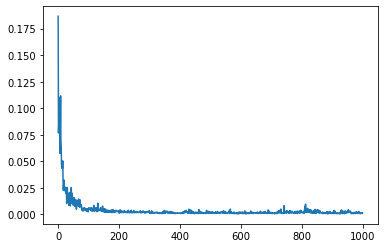

In [14]:
model = EyeTrackingCNN(coords_len)
model = train(model, dl)

In [15]:
def save_model(model, fname='model_v1'):
    torch.save(model.state_dict(), f'{fname}.pth')
    
def load_model(coords_len, fname='model_v1'):
    model = EyeTrackingCNN(coords_len)
    model.load_state_dict(torch.load('model_v1.pth'))
    return model

save_model(model)

### 4) Testing the Model

Finally, lets test out our model. Run the block below and see if your eyes can control your mouse on screen. Granted, it will be a bit jumpy, but it should work fairly well to predict the general area of the screen you're looking at.

In [16]:
import time

runtime = 20

def test_model(model, dl, duration=10):
    """
    Test a model on the datalWoader for <duration> number of seconds
    """
    screenshots = []
    webcam_images = []
    locations = []
    # Turn off gradients
    with torch.no_grad():
        # Set model to eval mode
        model.eval()
        
        # Record start time
        start_time = time.time()

        # Set elapsed time to 0
        elapsed = 0

        # Get screen size
        screen_x, screen_y = pag.size()
        
        dl.feat_extractor.start()
        
        # Loop while elapsed time < duration
        while elapsed < duration:
            # Get current frame, face/eye center coordinates
            features = dl.get_inference_pair()
            if features is None:
                continue
            imgs, fcenter, ecenter = features
            # Pass to model
            coords = model(imgs, fcenter, ecenter)
            # Convert coordinate to x,y clipping within screen dimensions
            coords = coords.detach().cpu().squeeze(0)
            x, y = coords[0]*dl.screen_res[0], coords[1]*dl.screen_res[1]
            x, y = int(torch.clip(x, 1, screen_x-10).item()), int(torch.clip(y, 1, screen_y-10).item())
            
            # Move mouse to predicted coordinate
            pag.moveTo(x, y)
            screenshots.append(pag.screenshot())
            locations.append((x, y))
            webcam_images.append(imgs.detach().cpu().squeeze(0).numpy())
            
            # Update elapsed time
            stop_time = time.time()
            elapsed = stop_time-start_time
    dl.feat_extractor.stop()
    
    return screenshots, webcam_images, locations

In [17]:
screenshots, webcam_images, locations = test_model(model, dl, runtime)

Video Capture Started
Video Capture Stopped


#### Saving a gif of the test

In [18]:
def create_frames(screenshots, webcam_images, locations):
    frames = []
    i = 0
    for i in range(len(screenshots)):
        screenshot, webcam_img, loc = np.asarray(screenshots[i]), webcam_images[i], locations[i]

        # Unfold webcam images, put them side by side, and increase the size
        cam_img = np.concatenate((webcam_img[0], webcam_img[1]), axis=1)
        cam_img = np.stack((cam_img, cam_img, cam_img), axis=2)
        cam_img = cv2.resize(cam_img, None, fx=10, fy=10, interpolation= cv2.INTER_LINEAR)

        # Pad webcam image to be of same shape as screen, pasted in the center
        cam_h, cam_w = cam_img.shape[:2]
        screen_h, screen_w = screenshot.shape[:2]
        top_pad = int((screen_h-cam_h)/2)
        bottom_pad = np.ceil((screen_h-cam_h)/2) if ((screen_h-cam_h)/2)%1 == 0.5 else int((screen_h-cam_h)/2)
        left_pad = int((screen_w-cam_w)/2)
        right_pad = np.ceil((screen_w-cam_w)/2) if ((screen_w-cam_w)/2)%1 == 0.5 else int((screen_w-cam_w)/2)
        cam_img_padded = cv2.copyMakeBorder(cam_img, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT)
        cam_img_padded = np.flip(cam_img_padded, axis=1)

        # rename to foreground and background, set alpha channel of foreground to have transparant borders
        background = screenshot.astype(np.float32)/255
        foreground = cam_img_padded

        # Calculate foreground alpha channel
        foreground_mask = (foreground[:,:,0] != 0).astype(np.uint)

        # Convert images to alpha channel and load in foreground mask as alpha channel for foreground
        background = cv2.cvtColor(background, cv2.COLOR_RGB2RGBA)
        foreground = cv2.cvtColor(foreground, cv2.COLOR_RGB2RGBA)
        foreground[:,:,3] = foreground_mask/2

        # Overlay the foreground ontop of the backround
        alpha_background = background[:,:,3]
        alpha_foreground = foreground[:,:,3]
        for color in range(0, 3):
            background[:,:,color] = alpha_foreground * foreground[:,:,color] + \
                alpha_background * background[:,:,color] * (1 - alpha_foreground)
        background[:,:,3] = (1 - (1 - alpha_foreground) * (1 - alpha_background))
        
        # Draw marker on the overlayed image where the eyes have predicted to be looking at
        background = background[:,:,:3].astype(np.float)
        cv2.drawMarker(background, loc, color=[1,0,0], markerSize=100, thickness=5)
        
        # Append background to frames
        frames.append(background)
    return frames

frames = create_frames(screenshots, webcam_images, locations)

/tmp/ipykernel_23423/2248644155.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  background = background[:,:,:3].astype(np.float)


In [19]:
def save_gif(frames, fname='output.gif'):
    imgs = [Image.fromarray((frame[:,:,:3]*255).astype(dtype=np.uint8)) for frame in frames]
    img = imgs[0]  # extract first image from iterator
    img.save(fp=fname, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)
    
save_gif(frames, fname='custom_network_test.gif')

### 5) More Advanced Network (Pretrained + Fine-tuning)

Lets see if we can use a pretrained network and fine-tune it to our dataset instead. We're going to be using a pretrained ResNet-18 model. This model only accepts color images of 224x224, as opposed to our simple model which takes in greyscale images of 40x40. Since our webcam resolution isn't good enough to get images of the eyes of 224x224 (without upscaling the image) we'll settle with the image of the face. We'll keep the extra coordinates for the center of the face and eyes.

Below, we define the second dataloader which is only slightly adjusted to account for colored images and the new resolution. The rest of the code is mostly the same as before (training, testing etc)

In [20]:
class EyeMouseDataloader2(object):
    """
    Class which defines a dataloader that records webcam and mouse movement for 
    data collection phase, and allows for sampling batches of training samples 
    to train on.
    """
    def __init__(self, device, crop_to=(224,224), batch_size=32):
        """
        Initializes EyeMouseDataloader object
            device: device to convert batches and samples to
            crop_to: dimension which to crop the eyes to
            batch_size: batch_size used for training
        """
        # Set global variables
        self.crop_to = crop_to
        self.batch_size = batch_size
        self.device = device
        self.screen_res = (pag.size().width, pag.size().height)
        
        # Test if video device works, extract frame and save camera resolution
        self.feat_extractor = FeatureExtractor()
        
        # Define preprocessing/transformations for the images
        self.preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(self.crop_to),
        ])
        
        # Create empty dataset
        self.dataset = []
        
    def collect_data(self, iters=1000):
        """
        Collects data from webcam and mouse movement, stores in self.dataset
            iter: number of instances to collect
        """
        self.feat_extractor.start()
        pbar = tqdm(total=iters, position=0, leave=True)
        while len(self.dataset) < iters:
            sample = self.get_training_pair()
            if sample is None:
                continue
            img, fcenter, ecenter, target = sample
            if img is not None:
                img = self.preprocess(img)
                self.dataset.append((img.to(torch.float), fcenter.to(torch.float), ecenter.to(torch.float), target.to(torch.float)))
            pbar.update(1)
                
        self.feat_extractor.stop()
        pbar.close()
        
    def get_inference_pair(self):
        """
        Gets an inference pair for testing, meaning it captures an image
        from the webcam and returns the features, but no target
        """
        
        features = self.feat_extractor.extract_features()
        if features is None:
            return None
        else:
            frame, face, face_center, img_eyes, eye_center = features
        
        img = self.preprocess(face).unsqueeze(0)
        face_center = face_center.to(torch.float).unsqueeze(0)
        eye_center = eye_center.to(torch.float).unsqueeze(0)
        return img.to(self.device), face_center.to(self.device), eye_center.to(self.device)
        
        
    def get_training_pair(self):
        """
        Takes a picture of the webcam and current mouse position for trainig
        Returns
            img_eyes: image of the two eyes in greyscale, overlayed 
                on channel dimension
            face_center: center coordinate of face
            eye_center: center coordinates of eyes
            target: position of mouse
        """
        target = self.get_mouse_pos()
        features = self.feat_extractor.extract_features()
        if features is None:
            return None
        else:
            frame, face, face_center, img_eyes, eye_center = features
        
        return face, face_center, eye_center, target
    
    def sample_training_batch(self):
        """
        Samples a training batch of self.batch_size, on self.device for training
        """
        if len(self.dataset) == 0:
            raise ValueError('Dataset is empty. Collect data first by running start_collecting_data')
        
        # Randomly sample from self.dataset
        imgs, fcenters, ecenters, targets = zip(*random.sample(self.dataset, self.batch_size))
        # Stack batch into tensors (batch_size x ...)
        imgs = torch.stack(imgs, dim=0)
        fcenters = torch.stack(fcenters, dim=0)
        ecenters = torch.stack(ecenters, dim=0)
        targets = torch.stack(targets, dim=0)
    
        # Return batches on device
        return imgs.to(self.device), fcenters.to(self.device), ecenters.to(self.device), targets.to(self.device)
        
    def get_mouse_pos(self):
        """
        Gets the current mouse position as the target, 
        returns it as a tensor (x,y)
        """
        x, y = pag.position()
        x, y = x/self.screen_res[0], y/self.screen_res[1]
        target = torch.tensor(x), torch.tensor(y)
        target = torch.stack(target, dim=0).to(torch.float)
        
        return target
    
dl2 = EyeMouseDataloader2(device)
dl2.collect_data(1000)

Video Capture Started
Video Capture Started


100%|███████████████████████████████████████| 1000/1000 [01:06<00:00, 14.94it/s]

Video Capture Stopped


In [21]:
# Uncomment the line below in case the dataloader crashes and the webcam is still on
# dl2.feat_extractor.stop()

#### Define and fine-tune a pretrained ResNet-18 model

In [22]:
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class ResnetEyeTracker(nn.Module):
    def __init__(self, coords_dim):
        super(ResnetEyeTracker, self).__init__()
        
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True,)
        self.resnet.fc = Identity()
        
        self.fc = nn.Sequential(
            nn.Linear(512+coords_dim, 500),
            nn.Linear(500, 100),
            nn.Linear(100, 2)
        )
        
    def forward(self, img, fcenters, ecenters):
        res_out = self.resnet(img)
        
        ecenters = torch.flatten(ecenters, start_dim=1)
        ecenters = ecenters.to(torch.float)
        fcenters = fcenters.to(torch.float)
        x = torch.cat((res_out, fcenters, ecenters),dim=1)
        out = self.fc(x)
        return out
    
    
# Sample a training batch to test the network
imgs, fcenter, ecenters, targets = dl2.sample_training_batch()

# Calculate how large the added coordinates are so the network
# can be told how many extra inputs it should have for the linear layer
ecenters_len = np.multiply(*ecenters.shape[1:])
fcenters_len = fcenter.shape[1]
coords_len = ecenters_len + fcenters_len
        
model = ResnetEyeTracker(coords_len).to(device)
model.to(device)

out = model(imgs, fcenter, ecenters)

Using cache found in /home/kjw/.cache/torch/hub/pytorch_vision_v0.10.0
/home/kjw/anaconda3/envs/eyems2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/kjw/anaconda3/envs/eyems2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Model: 100%|█████████| 1000/1000 [01:01<00:00, 16.17it/s, Loss=0.00187]


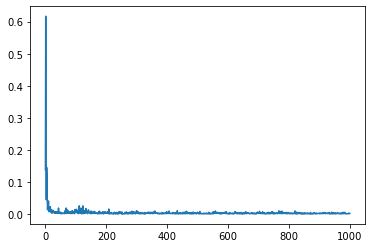

In [23]:
model = train(model, dl2)

In [27]:
save_model(model, fname='resnet_v1')

#### Testing the model in real-time

In [24]:
screenshots, webcam_images, locations = test_model(model, dl2, runtime)

Video Capture Started
Video Capture Stopped


#### Saving gif of the test

In [25]:
def create_frames(screenshots, webcam_images, locations):
    frames = []
    i = 0
    for i in range(len(screenshots)):
        screenshot, webcam_img, loc = np.asarray(screenshots[i]), webcam_images[i], locations[i]

        # Change webcam image from (C,H,W) to (H,W,C) and increase size
        cam_img = np.moveaxis(webcam_img,0,-1)[:,:,[2,1,0]]
        cam_img = cv2.resize(cam_img, None, fx=3, fy=3, interpolation= cv2.INTER_LINEAR)

        # Pad webcam image to be of same shape as screen, pasted in the center
        cam_h, cam_w = cam_img.shape[:2]
        screen_h, screen_w = screenshot.shape[:2]
        top_pad = int((screen_h-cam_h)/2)
        bottom_pad = int(np.ceil((screen_h-cam_h)/2)) if ((screen_h-cam_h)/2)%1 == 0.5 else int((screen_h-cam_h)/2)
        left_pad = int((screen_w-cam_w)/2)
        right_pad = int(np.ceil((screen_w-cam_w)/2)) if ((screen_w-cam_w)/2)%1 == 0.5 else int((screen_w-cam_w)/2)
        cam_img_padded = cv2.copyMakeBorder(cam_img, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT)
        cam_img_padded = np.flip(cam_img_padded, axis=1)

        # rename to foreground and background, set alpha channel of foreground to have transparant borders
        background = screenshot.astype(np.float32)/255
        foreground = cam_img_padded

        # Calculate foreground alpha channel
        foreground_mask = (foreground[:,:,0] != 0).astype(np.uint)

        # Convert images to alpha channel and load in foreground mask as alpha channel for foreground
        background = cv2.cvtColor(background, cv2.COLOR_RGB2RGBA)
        foreground = cv2.cvtColor(foreground, cv2.COLOR_RGB2RGBA)
        foreground[:,:,3] = foreground_mask/2

        # Overlay the foreground ontop of the backround
        alpha_background = background[:,:,3]
        alpha_foreground = foreground[:,:,3]
        for color in range(0, 3):
            background[:,:,color] = alpha_foreground * foreground[:,:,color] + \
                alpha_background * background[:,:,color] * (1 - alpha_foreground)
        background[:,:,3] = (1 - (1 - alpha_foreground) * (1 - alpha_background))
        
        # Draw marker on the overlayed image where the eyes have predicted to be looking at
        background = background[:,:,:3].astype(np.float)
        cv2.drawMarker(background, loc, color=[1,0,0], markerSize=100, thickness=5)
        
        # Append background to frames
        frames.append(background)
    return frames


frames = create_frames(screenshots, webcam_images, locations)

/tmp/ipykernel_23423/3733259835.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  background = background[:,:,:3].astype(np.float)


In [26]:
save_gif(frames, fname='resnet.gif')